In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vision Workshop - Exploratory Data Analysis

## Overview

[Vision Workshop](https://github.com/mblanc/vision-workshop) is a series of labs on how to build an image classification system on Google Cloud. Throughout the Vision Workshop labs, you will learn how to read image data stored in data lake, perform exploratory data analysis (EDA), train a model, register your model in a model registry, evaluate your model, deploy your model to an endpoint, do real-time inference on your model.

### Objective

In this notebook, you will perform exploratory data analysis on the historical bank transactions stored in BigQuery. Please make sure you have completed the [environment setup notebook](00_environment_setup.ipynb) prior to running this notebook.

This lab uses the following Google Cloud services and resources:

- [Vertex AI](https://cloud.google.com/vertex-ai/)
- [Google Cloud Storage](https://cloud.google.com/storage)

Steps performed in this notebook:

- Read data from Google Cloud Storage
- Calculate summary statistics across image datasets
- Display samples of images

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Load configuration settings from the setup notebook

Set the constants used in this notebook and load the config settings from the `00_environment_setup.ipynb` notebook.

In [2]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = f"{PROJECT_ID}-vision-workshop"
config = !gsutil cat gs://{BUCKET_NAME}/config/notebook_env.py
print(config.n)
exec(config.n)


BUCKET_NAME          = "temp-vision-workshop-vision-workshop"
PROJECT              = "temp-vision-workshop"
REGION               = "europe-west4"
ID                   = "7l3oe"
MODEL_NAME           = "vision_workshop_model"
ENDPOINT_NAME        = "vision_workshop_endpoint"



### Import libraries

In [3]:
from google.cloud import storage
import io
import itertools
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from tqdm import tqdm

### Exploratory data analysis of image dataset in Google Cloud Storage

In this section, you'll explore some of the Vision Workshop data by running queries and creating a couple interactive plots.

In [4]:
client = storage.Client() 

# Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

blobs = list(client.list_blobs(BUCKET_NAME, prefix='flowers/'))

In [5]:
labels = [os.path.split(os.path.dirname(blob.name))[1] for blob in blobs]

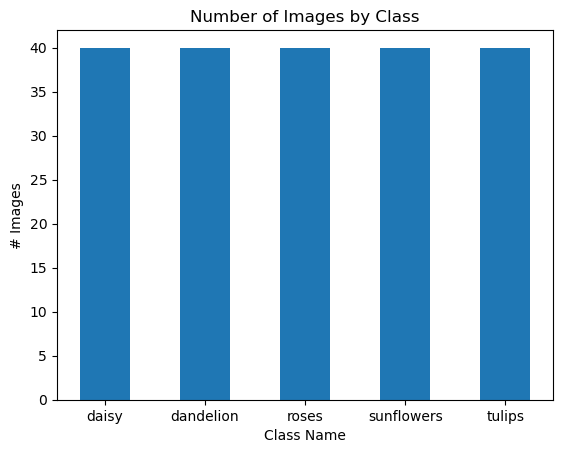

In [6]:
import collections

counter = collections.Counter(labels)

plt.bar(counter.keys(), counter.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

100%|██████████| 40/40 [00:01<00:00, 24.12it/s]


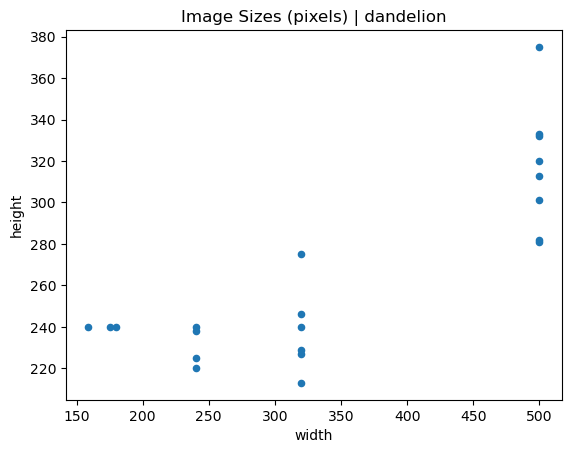

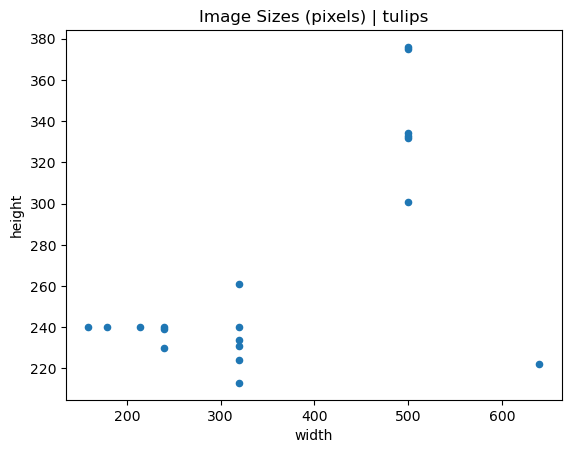

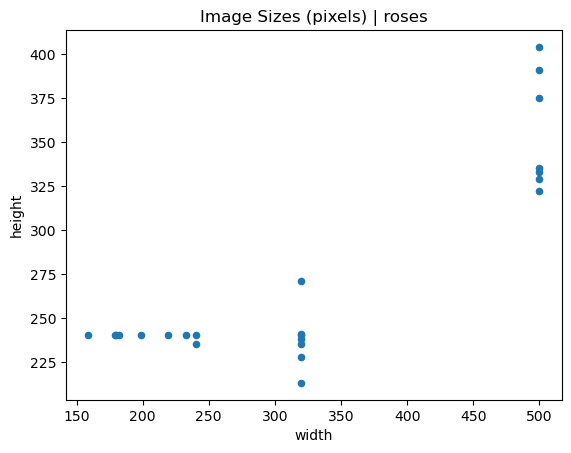

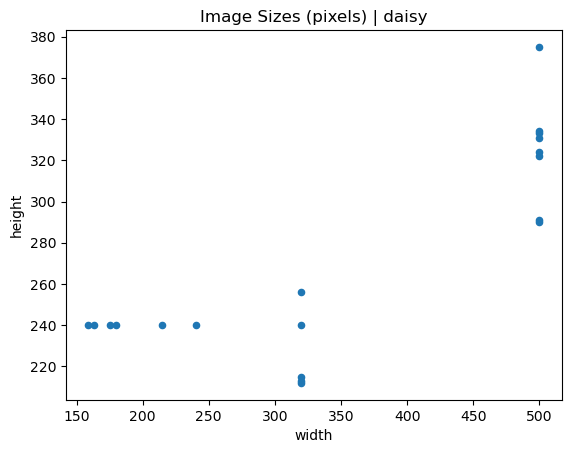

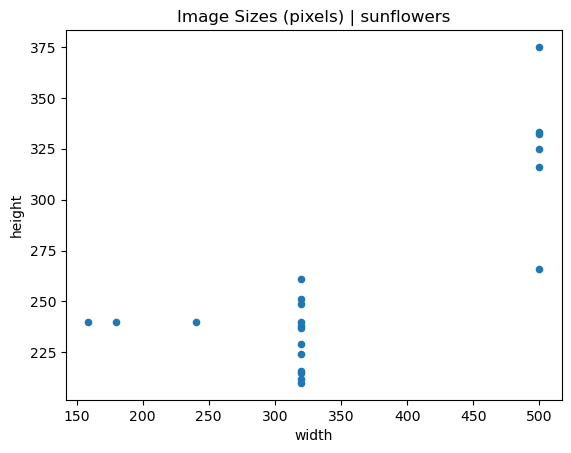

In [7]:
def get_dims(blob):
    '''Returns dimenstions for an RBG image'''
    image_data = blob.download_as_bytes()
    image = Image.open(io.BytesIO(image_data))
    arr = np.array(image)
    h,w,d = arr.shape
    return h,w

for label in set(labels):
    blobs = list(client.list_blobs(BUCKET_NAME, prefix=f'flowers/{label}/'))
    my_values = tqdm(blobs)
    dims = list(map(get_dims, my_values))
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

    sizes.plot.scatter(x='width', y='height')
    plt.title('Image Sizes (pixels) | {}'.format(label))

In [8]:
# Show images displayed 4x4
nrows = 2
ncols = 2

In [9]:
def show_image_sample(label):
    '''display 4x4 images'''
    blobs = list(client.list_blobs(BUCKET_NAME, prefix=f'flowers/{label}/'))[:4]
    fig = plt.gcf()
    plt.title(label)
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, blob in enumerate(blobs):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        image_data = blob.download_as_bytes()
        image = np.array(Image.open(io.BytesIO(image_data)))
        plt.imshow(image)
    plt.show()
    

dandelion


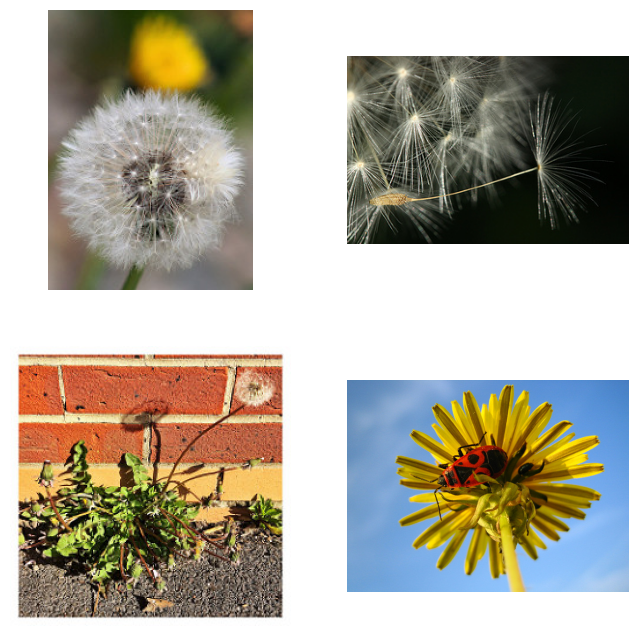

tulips


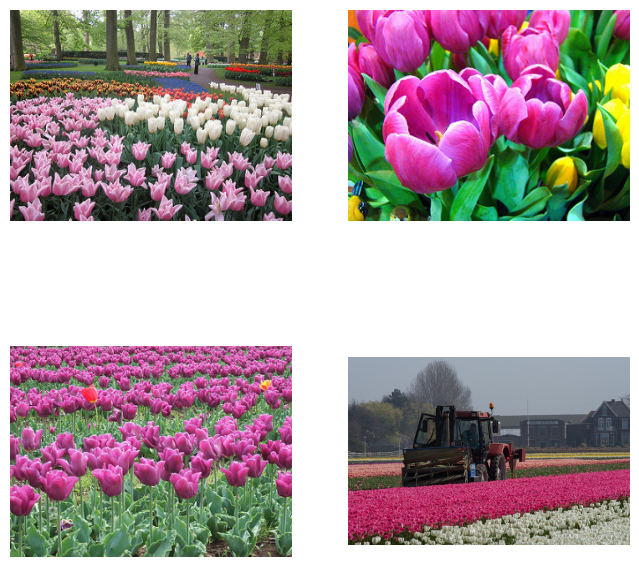

roses


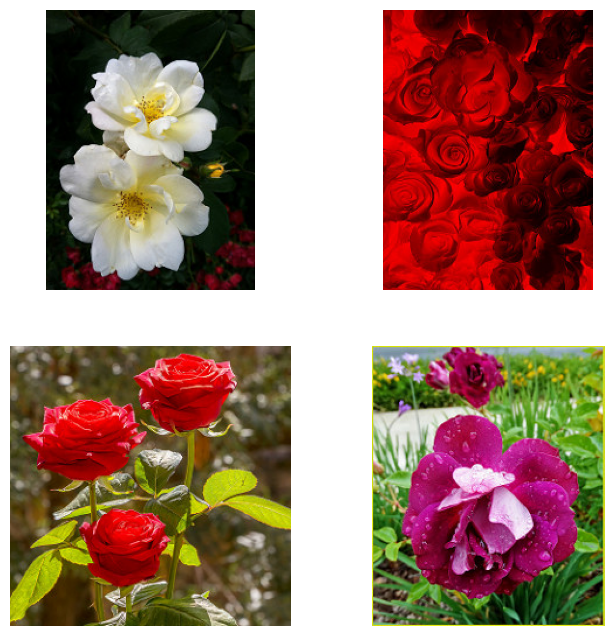

daisy


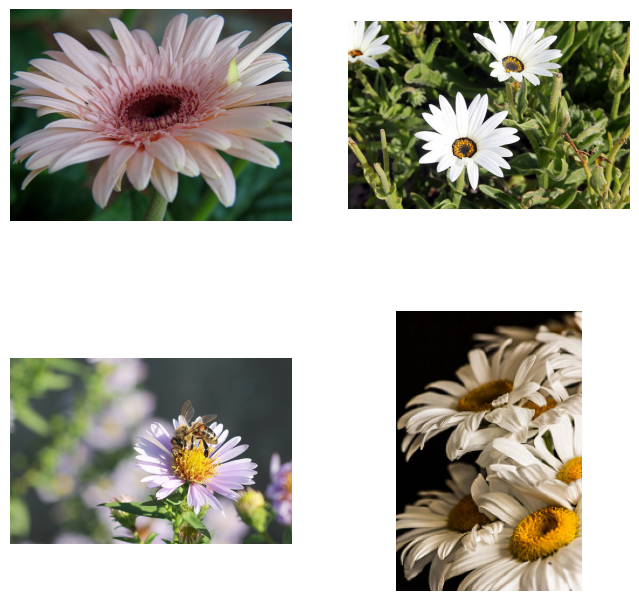

sunflowers


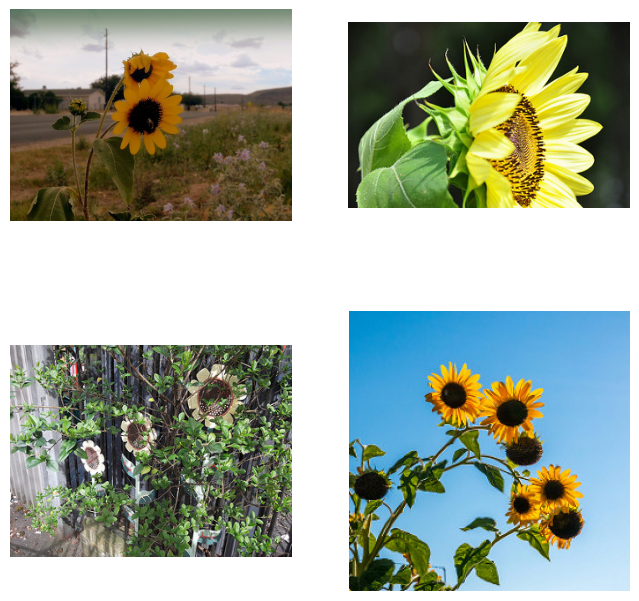

In [10]:
for label in set(labels):
    print(label)
    show_image_sample(label)

### END

Now you can go to the next notebook `vertex_ai/04_model_experimentation.ipynb`